# Installing aif dataset

In [1]:
!pip install 'aif360[LFR]'

     |████████████████████████████████| 175 kB 7.1 MB/s 
     |████████████████████████████████| 564 kB 52.7 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=f6ebe35e3a0fd39d7898a8238ba5bbe700651af379ad2931afa3370504ccf344
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [2]:
pip install fairlearn

     |████████████████████████████████| 177 kB 5.7 MB/s 


In [3]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test 

--2022-05-13 11:00:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  --.-KB/s    in 0.1s    

2022-05-13 11:00:07 (37.5 MB/s) - ‘adult.data’ saved [3974305/3974305]

--2022-05-13 11:00:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adult.names’

adult.names         100%[===================>]   5.11K  --.-KB/s    in 0s      

2022-

Installling the libraries

In [5]:

#Import the AIF360 library and set the random seed.
import numpy as np
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
import pdb
from sklearn.preprocessing import StandardScaler  #MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import *
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


np.random.seed(0)



Splitting the Adult dataset.

In [6]:
#Defining where's the bias in the features of our dataset.

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = load_preproc_data_adult(['sex'])


#Splitting between training and test set.
unscaled_adult_train, unscaled_adult_test = dataset_orig.split([0.7], shuffle=True,seed=np.random.seed(0))
print("training data size", unscaled_adult_train.features.shape)
print("dataset feature names", unscaled_adult_test.feature_names)



training data size (34189, 18)
dataset feature names ['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


# Task 1 (Adult Dataset)

In [7]:
#Creating a function to calculate the Accuracy while tuning the hyperparameter
def cross_validation_adult(utrain,utest,s,e,l,splits):
  c_value=np.logspace(s,e,l)
  cv = KFold(n_splits=splits, random_state=1, shuffle=True) #Defining a split function to split the training set into n splits
  average_metric={}
  acc=[]
  eq=[]
  ind=[]
  for i in c_value:
    learner = LogisticRegression(solver='liblinear', random_state=1, C=i)  #Initializing logistic regression function with hyperparameter C
    marray=[]
    aarray=[]
    for train_ix, test_ix in cv.split(utrain.features):

      train_x,test_x=utrain.subset(train_ix),utrain.subset(test_ix)
      scale_orig = StandardScaler()
      X_train = scale_orig.fit_transform(train_x.features)
      y_train = train_x.labels.ravel()
      X_test = scale_orig.transform(test_x.features) 
      y_test = test_x.labels.ravel()

      learner.fit(X_train,y_train)
      predictions = learner.predict(X_test)
      test_pred = test_x.copy()
      test_pred.labels = predictions
      
      metric = ClassificationMetric(test_x, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
      marray.append((metric.equal_opportunity_difference()))
      aarray.append(sum(predictions==y_test)/len(y_test))
    average_metric[i]=np.mean(marray)
    eq.append(average_metric[i])
    acc.append(np.mean(aarray))
    ind.append(i)
  for i,v in average_metric.items():
    print("for indexes {} the Equal opportunity value is : {}".format(i,v))
  print('Equal opportunity:',eq)
  print('Accuracy', acc)
  return(acc,eq,ind)

In [8]:
#Calling the cross validation function by passing the
eq_cva=[]
acc_cva=[]
ind_cva=[]
acc_cva,eq_cva,ind_cva=cross_validation_adult(unscaled_adult_train,unscaled_adult_test,0,-10,5,5)

for indexes 1.0 the Equal opportunity value is : -0.4657143725487554
for indexes 0.0031622776601683794 the Equal opportunity value is : -0.4631188426280633
for indexes 1e-05 the Equal opportunity value is : -0.23060303341214533
for indexes 3.162277660168379e-08 the Equal opportunity value is : -0.23831720531925935
for indexes 1e-10 the Equal opportunity value is : -0.23831720531925935
Equal opportunity: [-0.4657143725487554, -0.4631188426280633, -0.23060303341214533, -0.23831720531925935, -0.23831720531925935]
Accuracy [0.8039427862340653, 0.803591806415405, 0.7948462041975807, 0.7938517613780428, 0.7938517613780428]


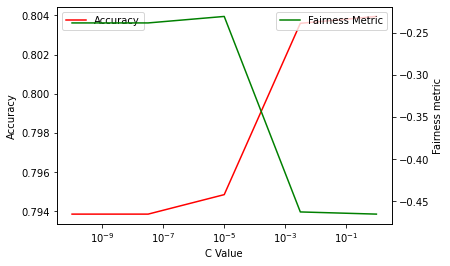

In [9]:
#Plotting the Graph 
import matplotlib.pyplot as plt

fig,ax=plt.subplots()
ax.plot(ind_cva,acc_cva,color='red',label='Accuracy')
plt.xscale('log')
ax.set_xlabel('C Value')
ax.set_ylabel('Accuracy')
ax2=ax.twinx()
ax2.plot(ind_cva,eq_cva,color='green',label='Fairness Metric')
ax2.set_ylabel('Fairness metric')
ax.legend()
ax2.legend()
plt.show()

In [10]:
#Function for Tesing the entire set
def full_test_adult(train,test,c):
      scale_orig = StandardScaler()
      X_train = scale_orig.fit_transform(train.features)
      y_train = train.labels.ravel()

      X_test = scale_orig.transform(test.features) 
      y_test = test.labels.ravel()

      learner = LogisticRegression(solver='liblinear', random_state=1,C=c)  
      learner.fit(X_train,y_train)
      predictions = learner.predict(X_test)

      test_pred = test.copy()
      test_pred.labels = predictions
      print("Accuracy", sum(predictions==y_test)/len(y_test))
      metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
      metric_arrs = {}
      metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
      print("Equal opportunity:")
      print(metric_arrs['eq_opp_diff'])


In [11]:
#Calling the Full test function for both values of C
print("Model with highest accuracy:") #Passing value of C which gave us the highest accuracy
full_test_adult(unscaled_adult_train,unscaled_adult_test,1.0)
print("Model with best fairness metric")#Passing value of C which gave us the best Equal opportunity difference
full_test_adult(unscaled_adult_train,unscaled_adult_test,0.00001)

Model with highest accuracy:
Accuracy 0.8042039172865625
Equal opportunity:
-0.4414141414141414
Model with best fairness metric
Accuracy 0.7975841124684365
Equal opportunity:
-0.2189742958035641


# Task 2(Adult dataset)

In [12]:
#Creating cross validation function with Reweighing, which is an algorithmic fairness method. 
def Reweighing_adult(utrain,utest,s,e,l,splits):
  c_value=np.logspace(s,e,l)
  cv = KFold(n_splits=splits, random_state=1, shuffle=True)
  average_metric={}
  acc=[]
  eq=[]
  ind=[]
  for i in c_value:
    learner = LogisticRegression(solver='liblinear', random_state=1, C=i)
    marray=[]
    aarray=[]
    for train_ix, test_ix in cv.split(utrain.features):

      train_x,test_x=utrain.subset(train_ix),utrain.subset(test_ix)
      scale_orig = StandardScaler()
      X_train = scale_orig.fit_transform(train_x.features)
      y_train = train_x.labels.ravel()
      X_test = scale_orig.transform(test_x.features) 
      y_test = test_x.labels.ravel()
      
      
      RW = Reweighing(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups) #Mitigating the bias
      train = RW.fit_transform(train_x) #Obtaining a set of weights for the training set
      learner.fit(X_train,y_train,sample_weight=train.instance_weights) #Using the classifier as before but we use the instance weights in the training phase.
      predictions = learner.predict(X_test)
      test_pred = test_x.copy()
      test_pred.labels = predictions
      
      metric = ClassificationMetric(test_x, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
      marray.append((metric.equal_opportunity_difference()))
      aarray.append(sum(predictions==y_test)/len(y_test))
    average_metric[i]=np.mean(marray)
    eq.append(average_metric[i])
    acc.append(np.mean(aarray))
    ind.append(i)
  for i,v in average_metric.items():
    print("for indexes {} the Equal opportunity value is : {}".format(i,v))
  print('Equal opportunity:',eq)
  print('Accuracy',acc)
  return(acc,eq,ind)

In [13]:
eq_ra=[]
acc_ra=[]
ind_ra=[]

acc_ra,eq_ra,ind_ra=Reweighing_adult(unscaled_adult_train,unscaled_adult_test,0,-10,5,5)

for indexes 1.0 the Equal opportunity value is : -0.010798338894180548
for indexes 0.0031622776601683794 the Equal opportunity value is : -0.010798338894180548
for indexes 1e-05 the Equal opportunity value is : -0.0019002020841960344
for indexes 3.162277660168379e-08 the Equal opportunity value is : -0.0029552411870439
for indexes 1e-10 the Equal opportunity value is : -0.0029552411870439
Equal opportunity: [-0.010798338894180548, -0.010798338894180548, -0.0019002020841960344, -0.0029552411870439, -0.0029552411870439]
Accuracy [0.7896983590183363, 0.7896983590183363, 0.7865394251458449, 0.7864809285094014, 0.7864809285094014]


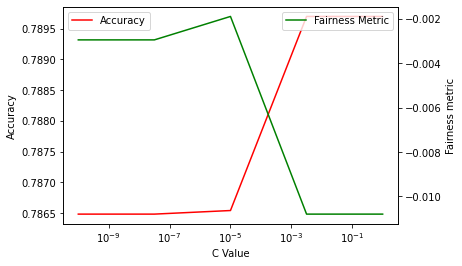

In [14]:
#Plotting the Graph 
fig,ax=plt.subplots()
ax.plot(ind_ra,acc_ra,color='red',label='Accuracy')
plt.xscale('log')
ax.set_xlabel('C Value')
ax2=ax.twinx()
ax2.plot(ind_ra,eq_ra,color='green',label='Fairness Metric')
ax.set_ylabel('Accuracy')
ax2.set_ylabel('Fairness metric')
ax.legend()
ax2.legend()
plt.show()

In [16]:
#Doing full test with reweighing
def full_test_reweighing_adult(train,test,c):
      scale_orig = StandardScaler()
      X_train = scale_orig.fit_transform(train.features)
      y_train = train.labels.ravel()

      X_test = scale_orig.transform(test.features) 
      y_test = test.labels.ravel()

      RW = Reweighing(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
      train = RW.fit_transform(train)
      
      learner = LogisticRegression(solver='liblinear', random_state=1,C=c)  
      learner.fit(X_train,y_train,sample_weight=train.instance_weights)


      predictions = learner.predict(X_test)

      test_pred = test.copy()
      test_pred.labels = predictions
      print("Accuracy", sum(predictions==y_test)/len(y_test))
      metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
      metric_arrs = {}
      metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
      print("Equal opportunity:")
      print(metric_arrs['eq_opp_diff'])
     

In [17]:
print("Model with highest accuracy:")
full_test_reweighing_adult(unscaled_adult_train,unscaled_adult_test,1.0)
print("Model with best fairness metric")
full_test_reweighing_adult(unscaled_adult_train,unscaled_adult_test,0.00001)

Model with highest accuracy:
Accuracy 0.7905548351873336
Equal opportunity:
0.03513180586351322
Model with best fairness metric
Accuracy 0.7876202825359995
Equal opportunity:
0.03327174180832715


# German Dataset



In [18]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/german


/usr/local/lib/python3.7/dist-packages/aif360/data/raw/german


In [19]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc


--2022-05-13 11:00:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german.data’

german.data         100%[===================>]  77.92K  --.-KB/s    in 0.02s   

2022-05-13 11:00:38 (3.26 MB/s) - ‘german.data’ saved [79793/79793]

--2022-05-13 11:00:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4679 (4.6K) [application/x-httpd-php]
Saving to: ‘german.doc’

german.doc          100%[===================>]   4.57K  --.-KB/s    in 0s 

In [20]:
#In this dataset, its about credit and its dependent on age, hence we are setting privileged group and unprivileged group with Age
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]
dataset_orig = load_preproc_data_german(['age']) 


# We split between training and test set.
unscaled_german_train, unscaled_german_test = dataset_orig.split([0.7], shuffle=True,seed=np.random.seed(0))
print("training data size", unscaled_german_train.features.shape)
print("dataset feature names", unscaled_german_train.feature_names)


training data size (700, 11)
dataset feature names ['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


# Task 1 German

In [21]:
#The cross validation function is same as that of the adult dataset.
def cross_validation_german(utrain,utest,s,e,l,splits):
  c_value=np.logspace(s,e,l)
  cv = KFold(n_splits=splits, random_state=1, shuffle=True)
  average_metric={}
  acc=[]
  eq=[]
  ind=[]
  for i in c_value:
    learner = LogisticRegression(solver='liblinear', random_state=1, C=i)
    marray=[]
    aarray=[]
    for train_ix, test_ix in cv.split(utrain.features):

      train_x,test_x=utrain.subset(train_ix),utrain.subset(test_ix)
      scale_orig = StandardScaler()
      X_train = scale_orig.fit_transform(train_x.features)
      y_train = train_x.labels.ravel()
      X_test = scale_orig.transform(test_x.features) 
      y_test = test_x.labels.ravel()

      learner.fit(X_train,y_train)
      predictions = learner.predict(X_test)
      test_pred = test_x.copy()
      test_pred.labels = predictions
      
      metric = ClassificationMetric(test_x, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
      marray.append((metric.equal_opportunity_difference()))
      aarray.append(sum(predictions==y_test)/len(y_test))
    average_metric[i]=np.mean(marray)
    eq.append(average_metric[i])
    acc.append(np.mean(aarray))
    ind.append(i)
  for i,v in average_metric.items():
    print("for indexes {} the Equal opportunity value is : {}".format(i,v))
  print('Equal opportunity:',eq)
  print('Accuracy',acc)
  return(acc,eq,ind)


In [22]:
eq_cva_g=[]
acc_cva_g=[]
ind_cva_g=[]
acc_cva_g,eq_cva_g,ind_cva_g=cross_validation_german(unscaled_german_train,unscaled_german_test,0,-10,5,5)

for indexes 1.0 the Equal opportunity value is : -0.37959871489859254
for indexes 0.0031622776601683794 the Equal opportunity value is : -0.5411661055596405
for indexes 1e-05 the Equal opportunity value is : -0.48848364933793553
for indexes 3.162277660168379e-08 the Equal opportunity value is : -0.48848364933793553
for indexes 1e-10 the Equal opportunity value is : -0.48848364933793553
Equal opportunity: [-0.37959871489859254, -0.5411661055596405, -0.48848364933793553, -0.48848364933793553, -0.48848364933793553]
Accuracy [0.69, 0.6728571428571428, 0.6414285714285713, 0.6414285714285713, 0.6414285714285713]


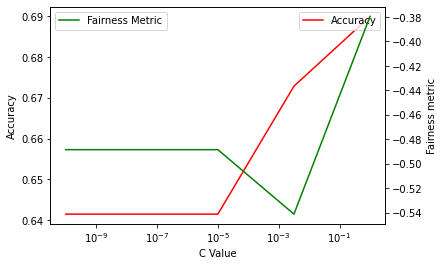

In [23]:
#Plotting the Graph 
fig,ax=plt.subplots()
ax.plot(ind_cva_g,acc_cva_g,color='red',label='Accuracy')
plt.xscale('log')
ax.set_xlabel('C Value')
ax.set_ylabel('Accuracy')
ax2=ax.twinx()
ax2.plot(ind_cva_g,eq_cva_g,color='green',label='Fairness Metric')
ax2.set_ylabel('Fairness metric')
ax.legend(loc='upper right')
ax2.legend()
plt.show()


In [24]:
#Doing a full test
def full_test_german(train,test,c):
      scale_orig = StandardScaler()
      X_train = scale_orig.fit_transform(train.features)
      y_train = train.labels.ravel()

      X_test = scale_orig.transform(test.features) 
      y_test = test.labels.ravel()

      learner = LogisticRegression(solver='liblinear', random_state=1,C=c)  
      learner.fit(X_train,y_train)
      predictions = learner.predict(X_test)

      test_pred = test.copy()
      test_pred.labels = predictions
      print("Accuracy", sum(predictions==y_test)/len(y_test))
      metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
      metric_arrs = {}
      metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
      print("Equal opportunity:")
      print(metric_arrs['eq_opp_diff'])
     

In [25]:
print("Model with highest accuracy:")
full_test_german(unscaled_german_train,unscaled_german_test,1.0)
print("Model with best fairness metric")
full_test_german(unscaled_german_train,unscaled_german_test,1.0)

Model with highest accuracy:
Accuracy 0.6966666666666667
Equal opportunity:
-0.4372261383120595
Model with best fairness metric
Accuracy 0.6966666666666667
Equal opportunity:
-0.4372261383120595


# Task 2 german

In [26]:
#doing the reweighing for the german dataset
def Reweighing_german(utrain,utest,s,e,l,splits):
  c_value=np.logspace(s,e,l)
  cv = KFold(n_splits=splits, random_state=1, shuffle=True)
  average_metric={}
  acc=[]
  eq=[]
  ind=[]
  for i in c_value:
    learner = LogisticRegression(solver='liblinear', random_state=1, C=i)
    marray=[]
    aarray=[]
    for train_ix, test_ix in cv.split(utrain.features):

      train_x,test_x=utrain.subset(train_ix),utrain.subset(test_ix)
      scale_orig = StandardScaler()
      X_train = scale_orig.fit_transform(train_x.features)
      y_train = train_x.labels.ravel()
      X_test = scale_orig.transform(test_x.features) 
      y_test = test_x.labels.ravel()
      
      
      RW = Reweighing(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
      train = RW.fit_transform(train_x)
      learner.fit(X_train,y_train,sample_weight=train.instance_weights)
      predictions = learner.predict(X_test)
      test_pred = test_x.copy()
      test_pred.labels = predictions
      
      metric = ClassificationMetric(test_x, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
      marray.append((metric.equal_opportunity_difference()))
      aarray.append(sum(predictions==y_test)/len(y_test))
    average_metric[i]=np.mean(marray)
    eq.append(average_metric[i])
    acc.append(np.mean(aarray))
    ind.append(i)
  for i,v in average_metric.items():
    print("for indexes {} the Equal opportunity value is : {}".format(i,v))
  print('Equal opportunity:',eq)
  print('Accuracy',acc)
  return(acc,eq,ind)



In [27]:
eq_ra_g=[]
acc_ra_g=[]
ind_ra_g=[]
acc_ra_g,eq_ra_g,ind_ra_g=Reweighing_german(unscaled_german_train,unscaled_german_test,0,-10,5,5)

for indexes 1.0 the Equal opportunity value is : 0.030607809261714934
for indexes 0.0031622776601683794 the Equal opportunity value is : 0.007540509462763967
for indexes 1e-05 the Equal opportunity value is : -0.2569217581184666
for indexes 3.162277660168379e-08 the Equal opportunity value is : -0.2569217581184666
for indexes 1e-10 the Equal opportunity value is : -0.2569217581184666
Equal opportunity: [0.030607809261714934, 0.007540509462763967, -0.2569217581184666, -0.2569217581184666, -0.2569217581184666]
Accuracy [0.6857142857142857, 0.6785714285714286, 0.6542857142857142, 0.6542857142857142, 0.6542857142857142]


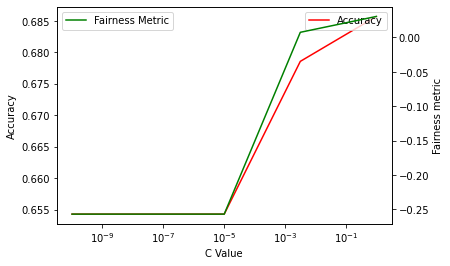

In [28]:
#Plotting the Graph 
fig,ax=plt.subplots()
ax.plot(ind_ra_g,acc_ra_g,color='red',label='Accuracy')
plt.xscale('log')
ax.set_xlabel('C Value')
ax.set_ylabel('Accuracy')
ax2=ax.twinx()
ax2.plot(ind_ra_g,eq_ra_g,color='green',label='Fairness Metric')
ax2.set_ylabel('Fairness metric')
ax.legend(loc='upper right')
ax2.legend()
plt.show()




In [29]:
def full_test_reweighing_german(train,test,c):
      scale_orig = StandardScaler()
      X_train = scale_orig.fit_transform(train.features)
      y_train = train.labels.ravel()

      X_test = scale_orig.transform(test.features) 
      y_test = test.labels.ravel()

      RW = Reweighing(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
      train = RW.fit_transform(train)
      
      learner = LogisticRegression(solver='liblinear', random_state=1,C=c)  
      learner.fit(X_train,y_train,sample_weight=train.instance_weights)

      
      predictions = learner.predict(X_test)

      test_pred = test.copy()
      test_pred.labels = predictions
      print("Accuracy", sum(predictions==y_test)/len(y_test))
      metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
      metric_arrs = {}
      metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
      print("Equal opportunity:")
      print(metric_arrs['eq_opp_diff'])
     

In [30]:
print("Model with highest accuracy:")
full_test_reweighing_german(unscaled_german_train,unscaled_german_test,1)
print("Model with best fairness metric")
full_test_reweighing_german(unscaled_german_train,unscaled_german_test,0.0031622776601683794)

Model with highest accuracy:
Accuracy 0.7066666666666667
Equal opportunity:
0.011049723756906049
Model with best fairness metric
Accuracy 0.7066666666666667
Equal opportunity:
0.06629834254143652


# Task 3

For the 3rd task,where we have to analysis of the machine learning methods beyond lecture materials, we are using random forest classifier

#Adult Dataset

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
#We define where's the bias in the features of our dataset.

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = load_preproc_data_adult(['sex'])


# We split between training and test set.
unscaled_train_adult_rf, unscaled_test_adult_rf = dataset_orig.split([0.7], shuffle=True,seed=np.random.seed(0))
print("training data size", unscaled_train_adult_rf.features.shape)
print("dataset feature names", unscaled_train_adult_rf.feature_names)

training data size (34189, 18)
dataset feature names ['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [33]:
#we are finding the accuracy and equal opportunity
def cross_validation_rnnfrst_adult(train,test):
      scale_orig = StandardScaler()
      X_train = scale_orig.fit_transform(train.features)
      y_train = train.labels.ravel()

      X_test = scale_orig.transform(test.features) 
      y_test = test.labels.ravel()

      learner = RandomForestClassifier(n_estimators=10,criterion='entropy')  #Initializing random forest classifier as learner
      learner.fit(X_train,y_train)
      predictions = learner.predict(X_test)

      test_pred = test.copy()
      test_pred.labels = predictions
      print("Accuracy", sum(predictions==y_test)/len(y_test))
      metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
      metric_arrs = {}
      metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
      print("Equal opportunity:")
      print(metric_arrs['eq_opp_diff'])
     

In [34]:
cross_validation_rnnfrst_adult(unscaled_train_adult_rf,unscaled_test_adult_rf)
#passsing the training and testing set to the function

Accuracy 0.8036579540025933
Equal opportunity:
-0.44612794612794615


In [35]:
#Using reweighing with th random forest classifier
def reweight_rndfrst_adult(train,test):
      scale_orig = StandardScaler()
      X_train = scale_orig.fit_transform(train.features)
      y_train = train.labels.ravel()

      X_test = scale_orig.transform(test.features) 
      y_test = test.labels.ravel()

      RW = Reweighing(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
      train = RW.fit_transform(train)
      
      learner = RandomForestClassifier(n_estimators=200)
      learner.fit(X_train,y_train,sample_weight=train.instance_weights)

      
      predictions = learner.predict(X_test)

      test_pred = test.copy()
      test_pred.labels = predictions
      print("Accuracy", sum(predictions==y_test)/len(y_test))
      metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
      metric_arrs = {}
      metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
      print("Equal opportunity:")
      print(metric_arrs['eq_opp_diff'])
     

In [36]:
#passing the testing and training adult dataset
reweight_rndfrst_adult(unscaled_train_adult_rf,unscaled_test_adult_rf)

Accuracy 0.7902818535453491
Equal opportunity:
0.0040198735320686185


#German Dataset

In [37]:
#Taking the german dataset
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]
dataset_orig = load_preproc_data_german(['age'])


#We split between training and test set.
unscaled_train_german_rf, unscaled_test_german_rf = dataset_orig.split([0.7], shuffle=True,seed=np.random.seed(0))
print("training data size", unscaled_train_german_rf.features.shape)
print("dataset feature names", unscaled_train_german_rf.feature_names)


training data size (700, 11)
dataset feature names ['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


In [38]:
#FInding the accuracy and Equal oppotunity for the german dataset with random forest classifier
def cross_validation_rnnfrst_german(train,test):
      scale_orig = StandardScaler()
      X_train = scale_orig.fit_transform(train.features)
      y_train = train.labels.ravel()

      X_test = scale_orig.transform(test.features) 
      y_test = test.labels.ravel()

      learner = RandomForestClassifier(n_estimators=100)  
      learner.fit(X_train,y_train)
      predictions = learner.predict(X_test)

      test_pred = test.copy()
      test_pred.labels = predictions
      print("Accuracy", sum(predictions==y_test)/len(y_test))
      metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
      metric_arrs = {}
      metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
      print("Equal opportunity:")
      print(metric_arrs['eq_opp_diff'])
     

In [43]:
cross_validation_rnnfrst_german(unscaled_train_german_rf,unscaled_test_german_rf)

Accuracy 0.69
Equal opportunity:
-0.1847971042103257


In [40]:
#Using reqeighing and then finding the accuracy and fairness
def reweight_rndfrst_german(train,test):
      scale_orig = StandardScaler()
      X_train = scale_orig.fit_transform(train.features)
      y_train = train.labels.ravel()

      X_test = scale_orig.transform(test.features) 
      y_test = test.labels.ravel()

      RW = Reweighing(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
      train = RW.fit_transform(train)
      
      learner = RandomForestClassifier(n_estimators=200)
      learner.fit(X_train,y_train,sample_weight=train.instance_weights)

      
      predictions = learner.predict(X_test)

      test_pred = test.copy()
      test_pred.labels = predictions
      print("Accuracy", sum(predictions==y_test)/len(y_test))
      metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
      metric_arrs = {}
      metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
      print("Equal opportunity:")
      print(metric_arrs['eq_opp_diff'])
     

In [42]:
reweight_rndfrst_german(unscaled_train_german_rf,unscaled_test_german_rf)

Accuracy 0.68
Equal opportunity:
-0.17374738045341964
